In [1]:
# referenced code here: https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/
# also found this interesting https://medium.com/@phindulo60/portfolio-optimization-with-python-mean-variance-optimization-mvo-and-markowitzs-efficient-64acb3b61ef6
# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

aapl = pd.read_csv("Dataset\Equities\AAPL.csv")
meta = pd.read_csv("Dataset\Equities\META.csv")
orcl = pd.read_csv("Dataset\Equities\ORCL.csv")
pep = pd.read_csv("Dataset\Equities\PEP.csv")

df_aapl = pd.DataFrame(data=aapl)
df_meta = pd.DataFrame(data=meta)
df_orcl = pd.DataFrame(data=orcl)
df_pep = pd.DataFrame(data=pep)
df_aapl.rename(columns={"Close": "aapl_close"}, inplace=True)
df_meta.rename(columns={"Close": "meta_close"}, inplace=True)
df_orcl.rename(columns={"Close": "orcl_close"}, inplace=True)
df_pep.rename(columns={"Close": "pep_close"}, inplace=True)
# print(df_aapl)

aapl_close = df_aapl["aapl_close"]
meta_close = df_meta["meta_close"]
orcl_close = df_orcl["orcl_close"]
pep_close = df_pep["pep_close"]


# print(aapl_close)
# print(meta_close)
# print(orcl_close)
assert aapl_close.shape == meta_close.shape == orcl_close.shape

date = pd.to_datetime(df_aapl["Date"])
portfolio = pd.DataFrame(date)
portfolio = portfolio.join(aapl_close)
portfolio = portfolio.join(meta_close)
portfolio = portfolio.join(orcl_close)
portfolio = portfolio.join(pep_close)
# print(portfolio)
# print(f"portfolio shape: {portfolio.shape}")

portfolio.set_index('Date', inplace=True)

In [2]:
num_entries, num_stocks = portfolio.shape
print(f"portfolio shape: {portfolio.shape}")
portfolio


portfolio shape: (2518, 4)


,aapl_close,meta_close,orcl_close,pep_close
Date,,,,
2014-05-27,22.343929,63.480000,41.910000,86.529999
2014-05-28,22.286072,63.509998,41.570000,87.070000
2014-05-29,22.692142,63.830002,42.200001,87.730003
2014-05-30,22.607143,63.299999,42.020000,88.330002
2014-06-02,22.451786,63.080002,41.970001,87.870003
...,...,...,...,...
2024-05-20,191.039993,468.839996,124.519997,180.309998
2024-05-21,192.350006,464.630005,124.629997,181.080002
2024-05-22,190.899994,467.779999,124.599998,182.089996


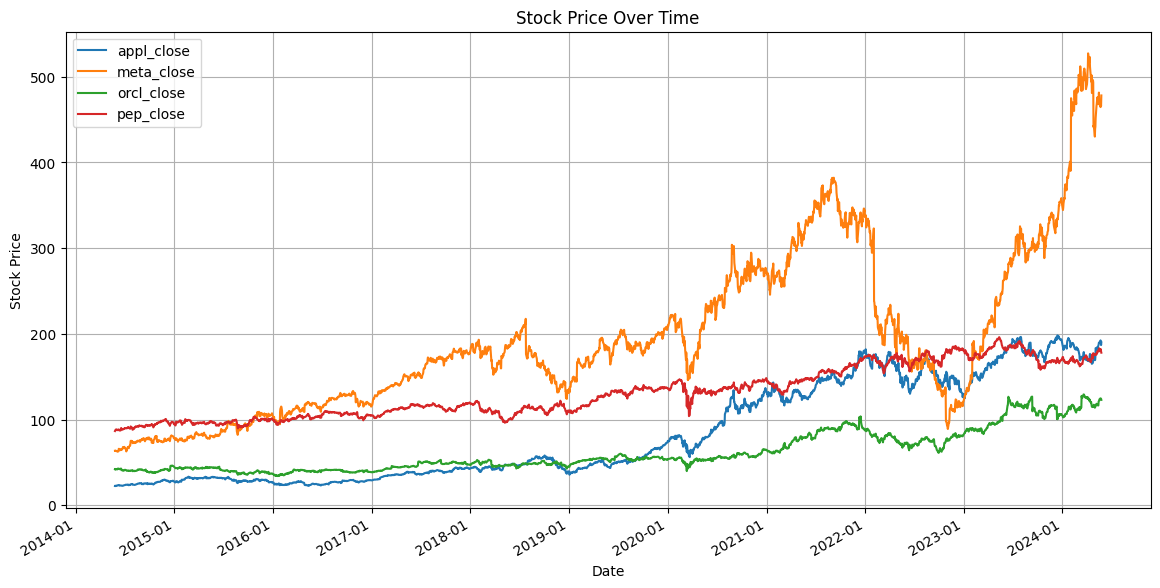

In [3]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(portfolio["aapl_close"], label="appl_close")
ax.plot(portfolio["meta_close"], label="meta_close")
ax.plot(portfolio["orcl_close"], label="orcl_close")
ax.plot(portfolio["pep_close"], label="pep_close")

ax.legend()

# Format x-ticks
ax.xaxis.set_major_locator(mdates.YearLocator())  # to display one tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # to format the date as 'YYYY-MM'

# Rotate date labels automatically
fig.autofmt_xdate()

ax.set_title('Stock Price Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.grid(True)

plt.show()

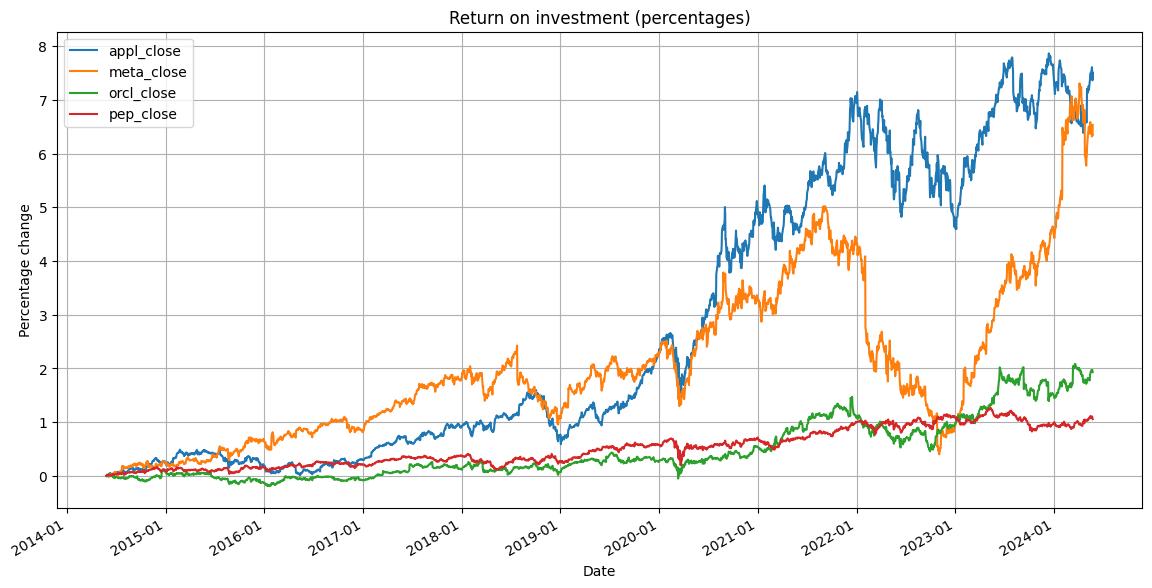

In [4]:
fig, ax = plt.subplots(figsize=(14, 7))
line1 = (portfolio["aapl_close"] - portfolio.iloc[(0, 0)]) / portfolio.iloc[(0, 0)]
line2 = (portfolio["meta_close"] - portfolio.iloc[(0, 1)]) / portfolio.iloc[(0, 1)]
line3 = (portfolio["orcl_close"] - portfolio.iloc[(0, 2)]) / portfolio.iloc[(0, 2)]
line4 = (portfolio["pep_close"] - portfolio.iloc[(0, 3)])/ portfolio.iloc[(0, 3)]
ax.plot(line1, label="appl_close")
ax.plot(line2, label="meta_close")
ax.plot(line3, label="orcl_close")
ax.plot(line4, label="pep_close")

ax.legend()

# Format x-ticks
ax.xaxis.set_major_locator(mdates.YearLocator())  # to display one tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # to format the date as 'YYYY-MM'

# Rotate date labels automatically
fig.autofmt_xdate()

ax.set_title('Return on investment (percentages)')
ax.set_xlabel('Date')
ax.set_ylabel('Percentage change')
ax.grid(True)

plt.show()

## Mean-Variance optimization (forecast)

Below is an implementation of MVO with target weights. Currently experiencing some issue (giving a single stock weight of 0).

In [5]:
from scipy.optimize import minimize

# Assume we have price data in a pandas DataFrame called 'portfolio'
# returns are in percentage
returns = portfolio.pct_change()

print(f"returns shape: {returns.shape}")

#! Let's set a target return of 9.0 (900%)
target_return = 5.0

# Calculate mean returns and covariance matrix
#! 252 is used to annualize the data (252 trading days in the US)
mean_returns = returns.mean() * 252
# mean_returns = daily_returns_pct_change.mean()
cov_matrix = returns.cov() * 252

# Define the objective function (portfolio variance)
def objective(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Define the constraint (portfolio return should be equal to the target return)
def constraint1(weights):
    return np.sum(mean_returns * weights) - target_return

# Define the constraint (the sum of the weights should be equal to 1)
def constraint2(weights):
    return np.sum(weights) - 1


# Define the bounds and constraints for the optimization
bounds = tuple((0,1) for x in range(num_stocks))
constraints = ({'type': 'eq', 'fun': constraint1},
               {'type': 'eq', 'fun': constraint2})

# Perform the optimization
initial_weights = np.ones(num_stocks) /num_stocks

result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

# Get the optimal portfolio weights
optimal_weights = result.x

returns shape: (2518, 4)


In [6]:
print(f"mean returns: {mean_returns}")
print(f"cov_matrix: {cov_matrix}")

mean returns: aapl_close    0.254529
meta_close    0.272802
orcl_close    0.142965
pep_close     0.089383
dtype: float64
cov_matrix:             aapl_close  meta_close  orcl_close  pep_close
aapl_close    0.080292    0.055899    0.035629   0.023088
meta_close    0.055899    0.139518    0.035887   0.019880
orcl_close    0.035629    0.035887    0.070855   0.020988
pep_close     0.023088    0.019880    0.020988   0.034252


(After Optim) initial portfolio values: 63.47999999999966
(After Optim) final portfolio values: 478.2200009999975


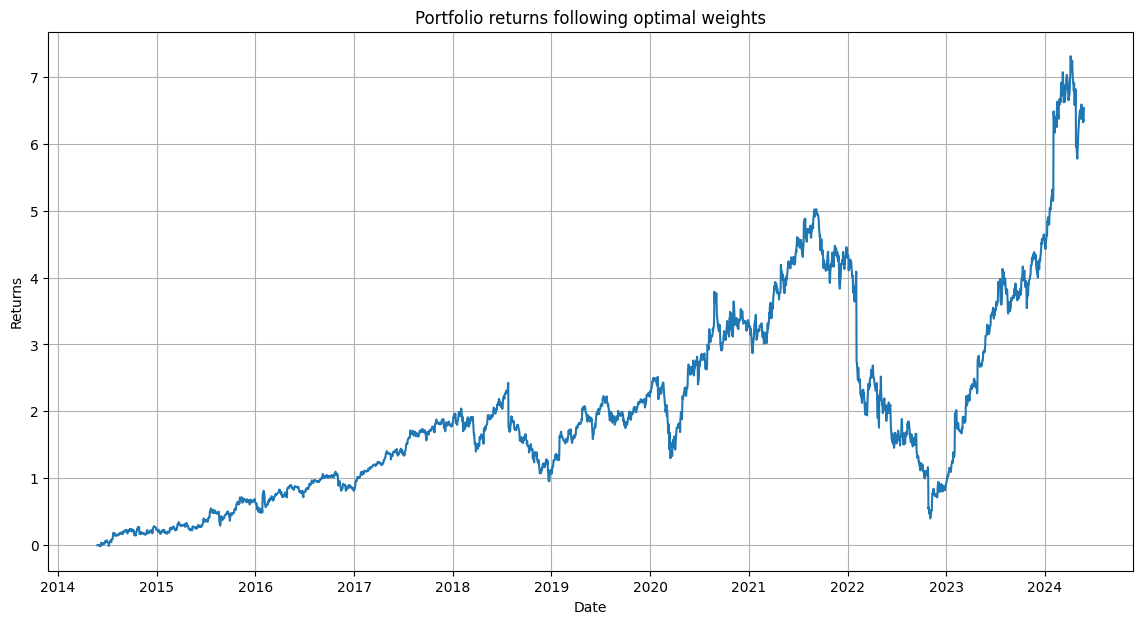

In [7]:
# print(f"num stocks: {num_stocks}")
# print(f"result type: {type(result)}")
# print(f"result: {result}")
# print(f"optimal_weights: {optimal_weights}")
# print(f"initial portfolio values: {portfolio.iloc[0, :]}")
# print(f"final portfolio values: {portfolio.iloc[-1, :]}")

#! setting too small values to zero
for i in range(len(optimal_weights)):
    if optimal_weights[i] < 1e-5:
        optimal_weights[i] = 0


portfolio_returns = np.dot(portfolio, optimal_weights)
portfolio_returns_pct_change = (portfolio_returns - portfolio_returns[0]) / portfolio_returns[0]
print(f"(After Optim) initial portfolio values: {portfolio_returns[0]}")
print(f"(After Optim) final portfolio values: {portfolio_returns[-1]}")

# Plot the portfolio returns

fig2, ax2 = plt.subplots(figsize=(14, 7))

ax2.plot(portfolio.index, portfolio_returns_pct_change)
ax2.set_title("Portfolio returns following optimal weights")
ax2.set_xlabel('Date')
ax2.set_ylabel('Returns')
ax2.grid(True)
plt.show()

## MVO w/ Risk aversion

It's roughly the same as MVO, but changed the multi-objective into a single objective, with a risk factor $\lambda$

In [8]:
# Risk aversion MVO

# Assume we have price data in a pandas DataFrame called 'portfolio'
# returns are in percentage
returns = portfolio.pct_change()

print(f"returns shape: {returns.shape}")

#! No target return, only how much risk the investor is willing to take
#! 0.0 is chasing max return without considering risk, 1.0 is minimizing risk
risk = 0.5

# Calculate mean returns and covariance matrix
#! 252 is used to annualize the data (252 trading days in the US)
mean_returns = returns.mean() * 252
# mean_returns = daily_returns_pct_change.mean()
cov_matrix = returns.cov() * 252

# Define the objective function (portfolio variance)
def objective(weights):
    return risk * np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) - (1 - risk) * np.sum(mean_returns * weights)


# Define the constraint (the sum of the weights should be equal to 1)
def constraint1(weights):
    return np.sum(weights) - 1


# Define the bounds and constraints for the optimization
bounds = tuple((0,1) for x in range(num_stocks))
constraints = ({'type': 'eq', 'fun': constraint1})

# Perform the optimization
initial_weights = np.ones(num_stocks) /num_stocks

result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

# Get the optimal portfolio weights
optimal_weights_risk = result.x

returns shape: (2518, 4)


(After Optim) initial portfolio values: 42.213617950514106
(After Optim) final portfolio values: 245.73302583065384


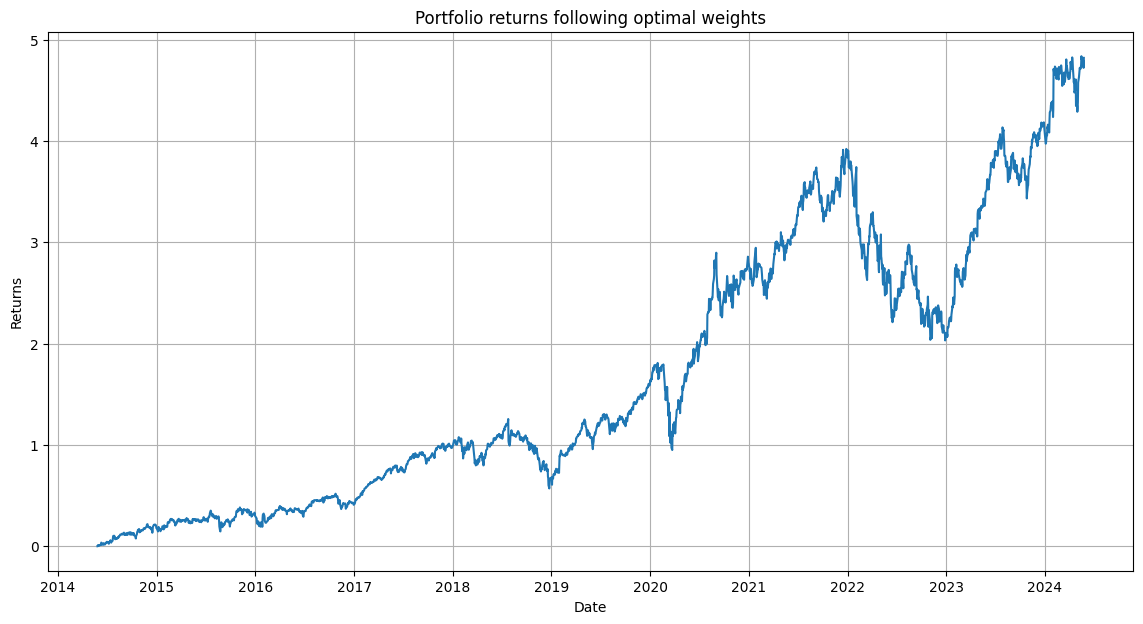

In [9]:
# print(f"optimal_weights: {optimal_weights_risk}")
# print(f"sum of weights: {np.sum(optimal_weights_risk)}")
# print(f"initial portfolio values: {portfolio.iloc[0, :]}")
# print(f"final portfolio values: {portfolio.iloc[-1, :]}")

#! setting too small values to zero
for i in range(len(optimal_weights)):
    if optimal_weights[i] < 1e-5:
        optimal_weights[i] = 0


portfolio_returns = np.dot(portfolio, optimal_weights_risk)
portfolio_returns_pct_change = (portfolio_returns - portfolio_returns[0]) / portfolio_returns[0]
print(f"(After Optim) initial portfolio values: {portfolio_returns[0]}")
print(f"(After Optim) final portfolio values: {portfolio_returns[-1]}")

# Plot the portfolio returns

fig2, ax2 = plt.subplots(figsize=(14, 7))

ax2.plot(portfolio.index, portfolio_returns_pct_change)
ax2.set_title("Portfolio returns following optimal weights")
ax2.set_xlabel('Date')
ax2.set_ylabel('Returns')
ax2.grid(True)
plt.show()